# Microglia migration persistence
In this notebook we compare the migration persistence of microglia between the ON and OFF state of the light activatable microtubule inhibitor PST1 (photostatin 1). To that end, we use the 3D tracks of microglia over time to calculate the 'mean square diplacement alpha' value following the approach of [1].

## Basic principle

The general idea is to sub-sample the tracks for different temporal step sizes and to subsequently determine the relation between the size of the step $n$ and the mean square displacement of a track resulting from that step size $\xi(n)$. 

In the case of a straight track with constant speed, there would be a quadratic relationship between the two. I.e.:

$\xi(n) = \frac{1}{N-n+1} \sum_{i=0}^{N-n} (x_{i+n} - x_{i})^2 = \frac{1}{N-n+1} \sum_{i=0}^{N-n} (an)^2 = (an)^2$

with the number of time points on the track $N$, the coordinates of the microglia $x_i$ and some constant length $a$.

For non-straight tracks $\xi(n)$ will always increase more slowly for increasing $n$. Therefore, we can assess the persistence of migration by performing a linear regression on $\log(\xi(n)) \sim \log(n)$. The slope of this regression $\alpha$ can then be used as a metric of migration persistance and would be $\alpha = 2$ in the linear case.

As a guide without further derivation, we can state that:
* $\alpha=2$: straight movement
* $1<\alpha<2$: directed movement with a random walk element (superdiffusion)
* $\alpha = 1$: diffusion
* $0<\alpha<1$: confined diffusion (subdiffusion)

[1] Gorelik, R., Gautreau, A. Quantitative and unbiased analysis of directional persistence in cell migration. Nat Protoc 9, 1931–1943 (2014). https://doi.org/10.1038/nprot.2014.131

## Imports and functions

In [2]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import tqdm
from scipy.stats import linregress

In [57]:
def mean_square_displacement(coords, n=0):
    """
    Calculate the mean square displacement of an objects trajectory.
    
    See https://www.nature.com/articles/nprot.2014.131 (eq. 3) for details.
    The subsampling parameter n controls the resolution of the track. I.e. for n=0 all points of the trajectory are used,
    for n=1 every other point of the trajectory is connected, n=2 will skip two points, etc. This is done to evaluate
    the track at different scales to enable the calculation of the MSD alpha value (see function MSD_alpha).
    
    :param coords: np.array, shape(n, 3) with x, y, z coordinates of the trajectory per row.
    :param n: subsampling parameter, see above.
    :return: float, MSD value
    """
    N = coords.shape[0] - 1  # number of steps
    if N-n+1 <= 0:
        raise ValueError('n has to be smaller than N + 1')
    disp = 0
    for i in range(N - n + 1):
        x_i = coords[i]
        x_i_n = coords[i + n]
        disp += ((x_i_n - x_i)**2).sum()
    return disp / (N - n)

def MSD_alpha(coords):
    """
    Alpha parameter of mean square displacement analysis.
    
    See https://www.nature.com/articles/nprot.2014.131 (eq. 3) for details about mean square displacement (MSD).
    We calculate the MSD for different subsamplings of the trajectory (varying n in the function mean_square_displacement).
    Then we draw the MSD value against the subsampling parameter n on a log-log scale and perform linear regression.
    The slope of the line is the MSD alpha parameter.
    It can be interpreted as:
    * alpha=2: straight movement
    * 2>alpha>1: superdiffusion, diffusion+direction
    * alpha=1: diffusion
    * 1>alpha>0: subdiffusion, some sort of confinement for the diffusion
    
    :param coords: np.array, shape(n, 3) with x, y, z coordinates of the trajectory per row.
    :return: float, MSD alpha value
    """
    N = coords.shape[0] - 1
    n_list = []
    MSD_list = []
    n = 2
    while N-n > 0:
        MSD_list.append(mean_square_displacement(coords, n))
        n_list.append(n)
        n += 1
    first_half_index = int(len(n_list) / 2)
    n_list = np.array(n_list)[:first_half_index]
    MSD_list = np.array(MSD_list)[:first_half_index]
    n_list = np.log(n_list)
    MSD_list = np.log(MSD_list)
    slope, intercept, r_value, p_value, std_err = linregress(n_list, MSD_list)
    return slope, p_value

## Load data
First, we load the data and organise it in a pd.DataFrame.

In [77]:
path_to_data = 'data/photostatin_migration_persistence/'

paths = glob.glob(path_to_data + '*.csv')

dfs = []
for i in range(len(paths)):
    sample_info = paths[i].split('.')[0].split('_')
    kmid = sample_info[2].split('/')[-1] + '-' + sample_info[-2][-1]
    pst_state = sample_info[-1]
    if kmid[:3] == 'kmx':
        skip = 5
    else:
        skip = 3
    sub_df = pd.read_csv(paths[i], skiprows=skip)
    
    
    sub_df['sample id'] = kmid  # unique sample id
    sub_df['PST-1'] = pst_state  # state of photostatin activation
    dfs.append(sub_df)
df = pd.concat(dfs)
df = df.drop(['Unit', 'Category', 'Collection', 'Unnamed: 9'], axis=1)
df = df.rename({'Position X': 'x', 'Position Y': 'y', 'Position Z': 'z', 'Time': 'frame', 'TrackID': 'track id', 'ID': 'id'}, axis=1)
df = df.reset_index(drop=True)

df['unique track id'] = df['track id'].astype(str) + '_' + df['sample id'] + '_' + df['PST-1']

df


,x,y,z,frame,track id,id,sample id,PST-1,unique track id
0,21209.9,-2970.91,-12.9653,1,1000000013,13,km188-1,OFF,1000000013_km188-1_OFF
1,21198.5,-2969.17,17.4269,1,1000000022,22,km188-1,OFF,1000000022_km188-1_OFF
2,21276.5,-2995.96,-14.7484,1,1000000035,35,km188-1,OFF,1000000035_km188-1_OFF
3,21302.3,-3035.19,-12.2238,1,1000000036,36,km188-1,OFF,1000000036_km188-1_OFF
4,21289.4,-3072.01,13.3270,1,1000000037,37,km188-1,OFF,1000000037_km188-1_OFF
...,...,...,...,...,...,...,...,...,...
11986,16675.1,-2423.37,10.2073,60,1000008690,25676,km191-3,ON,1000008690_km191-3_ON
11987,16553.8,-2338.13,19.1814,60,1000008704,25682,km191-3,ON,1000008704_km191-3_ON
11988,16748.1,-2430.75,33.9303,60,1000008695,25755,km191-3,ON,1000008695_km191-3_ON
11989,16635.7,-2376.30,33.9303,60,1000008680,25758,km191-3,ON,1000008680_km191-3_ON


## Generate MSD-alpha
Now we calculate the MSD $\alpha$ values.

In [82]:
list_df = []
for utid in df['unique track id'].unique():
    try:
        _sdf = df.loc[df['unique track id'] == utid]
        pst = _sdf['PST-1'].unique()[0]
        sid = _sdf['sample id'].unique()[0]
        msd, p = MSD_alpha(_sdf[list('xyz')].values)
        list_df.append(pd.DataFrame([[pst, sid, utid, msd, p]], columns=['PST-1', 'sample id', 'unique track id', 'MSDa','pval']))
    except ValueError:
        print(utid)
        print(_sdf)
df_msd = pd.concat(list_df)
df_msd

1000000016_kmx01-2_OFF
            x        y        z  frame    track id  id sample id PST-1  \
5236  21369.8 -3338.12  36.4278      1  1000000016  16   kmx01-2   OFF   
5259  21369.5 -3338.11  36.4278      2  1000000016  39   kmx01-2   OFF   
5282  21371.3 -3338.06  36.4278      3  1000000016  62   kmx01-2   OFF   
5304  21371.0 -3338.53  36.4278      4  1000000016  84   kmx01-2   OFF   

             unique track id  
5236  1000000016_kmx01-2_OFF  
5259  1000000016_kmx01-2_OFF  
5282  1000000016_kmx01-2_OFF  
5304  1000000016_kmx01-2_OFF  


,PST-1,sample id,unique track id,MSDa,pval
0,OFF,km188-1,1000000013_km188-1_OFF,1.307579,2.099848e-27
0,OFF,km188-1,1000000022_km188-1_OFF,1.044246,1.798095e-22
0,OFF,km188-1,1000000035_km188-1_OFF,1.382862,4.342253e-35
0,OFF,km188-1,1000000036_km188-1_OFF,1.500606,4.187687e-31
0,OFF,km188-1,1000000037_km188-1_OFF,1.376950,2.592443e-35
...,...,...,...,...,...
0,ON,km191-3,1000008690_km191-3_ON,1.042834,2.080742e-19
0,ON,km191-3,1000008695_km191-3_ON,0.736305,5.676399e-11
0,ON,km191-3,1000008700_km191-3_ON,1.412772,1.095310e-30
0,ON,km191-3,1000008704_km191-3_ON,1.215552,1.775902e-28


To see if the calculations of $\alpha$ (`MSDa`) were successful, we check the p-values of the associated linear regressions.

In [109]:
(df_msd['pval'] >= 0.005).any()

False

We find that none of the p-values exceed the threshold of 0.005. Therefore, we can be confident that the determination of $\alpha$ was sucessful.

## Plot results

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OFF v.s. ON: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.201e-04 U_stat=3.541e+03


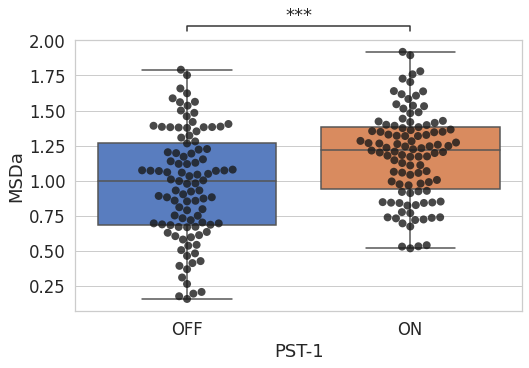

In [111]:
data = df_msd

sns.set(font_scale=1.5, style='whitegrid', palette='muted')
plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=data,
                    x='PST-1',
                    y='MSDa',
                    order=['OFF', 'ON'])
sns.swarmplot(data=data,
              x='PST-1',
              y='MSDa',
              order=['OFF', 'ON'],
              color='k',
              ax=ax, 
              s=8,
              alpha=.8)


add_stat_annotation(ax, 
                    data=data, 
                    x='PST-1',
                    y='MSDa',
                    order=['OFF', 'ON'],
                    box_pairs=[('OFF', 'ON')],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
plt.savefig('plots/pst_msda.pdf')